Import Necessary libraries and change directory

In [1]:
import cptac
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/mnt/c/Users/alanx/OneDrive/Desktop/QBIO490/analysis_data/')

In [74]:
# Downloading and loading GBM Data from CPTAC
cptac.download('GBM')
gbm = cptac.Gbm()

clinical = gbm.get_clinical() # Clinical Data
mutation = gbm.get_somatic_mutation() # Genomic Data
rna = gbm.get_transcriptomics() # Transcriptomic Data
protein = gbm.get_proteomics() # Proteomic Data
protein.columns = protein.columns.get_level_values(0) # Fix protein data columns

In [75]:
# Let's first screen out patients that don't have protein or rna info
clic_i = clinical.index
rna_i = rna.index
p_i = protein.index

union = np.intersect1d(clic_i,rna_i)
union = np.intersect1d(union,p_i)

clinical = clinical.loc[union,:]
rna = rna.loc[union,:]
protein = protein.loc[union,:]

In [76]:
# Only retaining cancerous tissues
cancer_mask = clinical.loc[:,"Sample_Tumor_Normal"] == "Tumor"
clinical_ca = clinical.loc[cancer_mask,:]
rna_ca = rna.loc[cancer_mask,:]
protein_ca = protein.loc[cancer_mask,:]

In [77]:
# Retaining only patients with vital status info
vit_mask = clinical_ca.loc[:,"vital_status"].notna()
clinical_ca_vit = clinical_ca.loc[vit_mask,:]
rna_ca_vit = rna_ca.loc[vit_mask,:]
protein_ca_vit = protein_ca.loc[vit_mask,:]

In [79]:
# Retaining patients with ALDOB protein expression & ALDOB RNA Expression
aldob_p = protein_ca_vit.loc[:,"ALDOB"].notna()
sum(aldob_p == False)

aldob_r = rna_ca_vit.loc[:,'ALDOB'].notna() 
sum(aldob_r.loc[:,"ENSG00000136872.16"] == False) # alias or ALDOB

0

In [81]:
# Retaining patients with SCL2A5 RNA/Protein Expression
slc_p = protein_ca_vit.loc[:,"SLC2A5"].notna()
sum(slc_p == False)

slc_r = rna_ca_vit.loc[:,"SLC2A5"].notna() 
sum(slc_r.loc[:,'ENSG00000142583.16'] == False) #alias for slc2a5

0

In [82]:
# Constructing the data and target columns
data = rna_ca_vit.loc[:,['ALDOB','SLC2A5']]
data = data.join(protein_ca_vit.loc[:,['ALDOB','SLC2A5']])
data.columns = ['ALDOB_RNA', 'SLC2A5_RNA', 'ALDOB_P', 'SLC2A5_P']
data

,ALDOB_RNA,SLC2A5_RNA,ALDOB_P,SLC2A5_P
Patient_ID,,,,
C3L-00104,2142.339921,127791.605887,0.448224,-0.203176
C3L-00365,216.243136,132562.373061,0.092742,-0.220352
C3L-00674,632.553079,286774.218581,0.729797,0.400117
C3L-00677,898.176634,67263.204125,-0.067300,-0.337668
C3L-01040,3745.732746,93170.113644,-0.704124,-0.299337
...,...,...,...,...
C3N-03088,4501.802972,292408.533493,-0.256082,0.955101
C3N-03182,0.000000,271901.696800,-0.468068,0.400563
C3N-03183,0.000000,154182.447020,-0.582615,0.284600


In [84]:
clinical_ca_vit.loc[:,'vital_status']

Patient_ID
C3L-00104    Deceased
C3L-00365    Deceased
C3L-00674    Deceased
C3L-00677    Deceased
C3L-01040      Living
               ...   
C3N-03088    Deceased
C3N-03182      Living
C3N-03183    Deceased
C3N-03186      Living
C3N-03188      Living
Name: vital_status, Length: 93, dtype: object

Text(0.5, 0, 'ML Method')

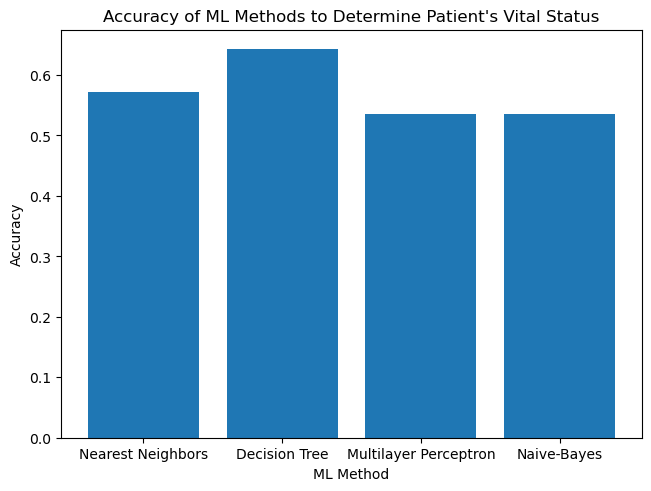

In [100]:
# Import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # default number of neighbors looked at is 5
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder

# Scaling the Data
scaler = StandardScaler()
data_x = scaler.fit_transform(data)

# Encoding the Result
encoder = OrdinalEncoder()
target = encoder.fit_transform(clinical_ca_vit.loc[:,'vital_status'].to_frame())

# set classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    GaussianNB()
]

classifiers_names = ['Nearest Neighbors', 'Decision Tree', 'Multilayer Perceptron', 'Naive-Bayes']

X_train, X_test, y_train, y_test = train_test_split(data_x, target, train_size=0.7)

# Training; testing and plotting
result = []
for i in range(len(classifiers)):
    model = classifiers[i]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    count = 0
    for j in range(len(y_pred)):
        if y_pred[j] == y_test[j]:
            count += 1
    result.append(count / len(y_test))
fig, axs = plt.subplots(1,1, constrained_layout=True)
axs.bar(classifiers_names,result)
axs.set_title("Accuracy of ML Methods to Determine Patient's Vital Status")
axs.set_ylabel("Accuracy")
axs.set_xlabel("ML Method")